## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Будем считать, что задача решена успешно, если значение метрики *RMSE* на тестовой выборке будет не больше 48.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

## Навигация
1.[Подготовка данных](#prep)
- [Преобразование типов данных](#dtypes)

2.[Анализ данных](#an)
- [Тренды и сеознность](#trends)
- [Создание новых признаков](#feature_gen)

3.[Обучение](#fit)
- [Linear Regression](#lin)
- [Catboost Regressor](#cat)

4.[Тестирование](#test)
- [Вывод](#result)

<a id='prep'></a>
# 1. Подготовка данных

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [3]:
taxi.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


Посмотрим общую информацию о датасете

In [4]:
taxi.shape

(26496, 2)

Видим, что имеем всего 2 столбца и 26.5 тысяч строк: дату и количество заказов в промежутках по 10 минут

А что с типами данных?

In [5]:
taxi.dtypes

datetime      object
num_orders     int64
dtype: object

<a id='dtypes'></a>
#### Приведение типов данных

Столбец `datetime` имеет тип данных **object**. Непорядок. Приведем его к типу **datetime**

In [6]:
taxi['datetime'] = pd.to_datetime(taxi['datetime']) 

Проверим, нет ли пропусков и/или дубликатов

In [7]:
print(f'Количесвто пропусков: {taxi.isnull().sum().sum()}')
print(f'Количество дубликатов: {taxi.duplicated().sum()}')

Количесвто пропусков: 0
Количество дубликатов: 0


Отлично, наш датасет можно назвать **чистым**.

Следующим шагом становим индексом дату заказа такси

In [8]:
taxi = taxi.set_index('datetime')
taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


Сделаем теперь ресемплирование по одному часу и воспользуемся функцией **sum** для аггрегации значений

In [9]:
taxi = taxi.resample('1H').sum()
taxi.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


<a id='an'></a>
# 2. Анализ данных

#### Графики скользящего среднего за разные временные промежутки

Посмотрим на график со скользящим среднем

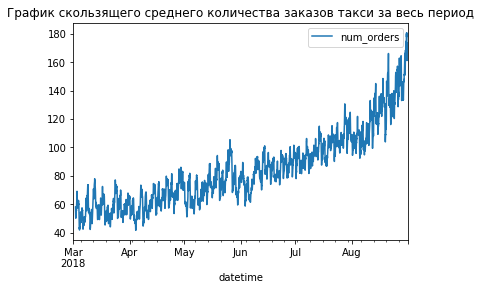

In [10]:
taxi.rolling(30).mean().plot(title='График скользящего среднего количества заказов такси за весь период')

В целом, видим скорее восходящий тренд по месяцам. Полагаю, это можно объяснить тем, что у аггрегатора такси увеличивалась клиентская база, что и способствовало глобальному росту количества заказов.

Взглянем детальнее на график, например, за первые две недели августа

In [11]:
two_weeks = taxi['2018-08-01':'2018-08-15']

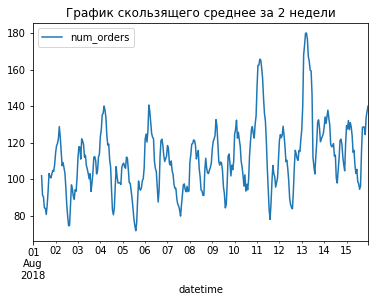

In [12]:
two_weeks.rolling(10).mean().plot(title='График скользящего среднее за 2 недели')

Видим сильные колебания. Посмотрим детальнее, например, за 2 дня

In [13]:
two_days = two_weeks['2018-08-05-00':'2018-08-07']

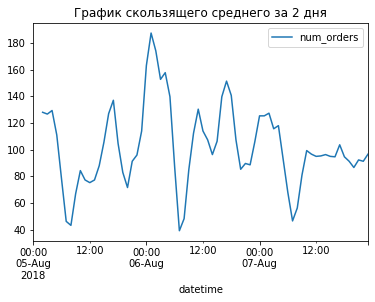

In [14]:
two_days.rolling(3).mean().plot(title='График скользящего среднего за 2 дня')

Более детальный график за 2 дня. Здесь тоже достаточно сильные колебания, однако, они выглядят закономерными как и на предыдущем графике

In [15]:
april_10 = taxi['2018-04-10':'2018-04-10']

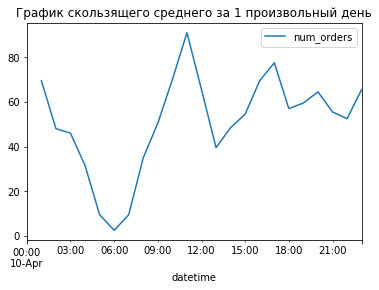

In [16]:
april_10.rolling(2).mean().plot(title='График скользящего среднего за 1 произвольный день')

Рассмотрев один произвольный (непраздничный день, который оказался средой) видим, что практически не было заказов в 6 утра. И в принципе, количество заказов после полуночи снижалось. Занимательно, что пик заказов пришелся на утреннее время до обеда. Возможно, 

<a id='trends'></a>
#### Тренды и сезонность

Так как у нас данные предоставлены даже не за год, а за полгода, то тяжело говорить о сезонности. Поэтому посмотрим на общий тренд

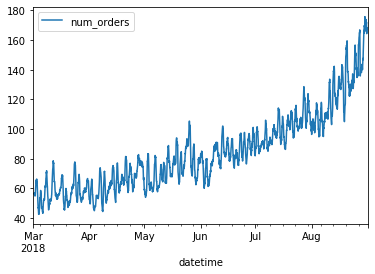

In [17]:
decomposed = seasonal_decompose(taxi) 
decomposed.trend.plot()

Как видим, общий тренд - увеличение количества заказов. Скорее всего это связано с ростом популярности аггрегатора

<a id='feature_gen'></a>
#### Создание новых признаков

Создадим новые признаки, чтобы улучшить качество прогноза. Добавим следующие признаки.
- Календарные (месяц, день недели)
- "Отстающие значения"
- Скользящее среднее

In [18]:
# календарные
taxi['month'] = taxi.index.month
taxi['dayofweek'] = taxi.index.dayofweek
taxi['hour'] = taxi.index.hour

In [19]:
# отстающие
lags = 75

for i in range(1, lags+1):
    taxi[f'lag_{i}'] = taxi['num_orders'].shift(i)

# скользящее среднее
rolling_window_size = 24
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(rolling_window_size).mean()

Избавимся от полученных `NaN` значений

In [20]:
taxi.dropna(inplace=True)
taxi.head(5)

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-04 03:00:00,42,3,6,3,26.0,60.0,75.0,43.0,63.0,48.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,48.125000
2018-03-04 04:00:00,27,3,6,4,42.0,26.0,60.0,75.0,43.0,63.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,47.208333
2018-03-04 05:00:00,22,3,6,5,27.0,42.0,26.0,60.0,75.0,43.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,46.500000
2018-03-04 06:00:00,11,3,6,6,22.0,27.0,42.0,26.0,60.0,75.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,46.791667
2018-03-04 07:00:00,12,3,6,7,11.0,22.0,27.0,42.0,26.0,60.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,46.875000


<a id='fit'></a>
# 3. Обучение

В первую очередь как обычно разобьем наши данные на `train` и `test`, но с тем учетом, что у временных рядов нельзя перемешивать данные. Поэтому в стандартном методе `train_test_split` укажем **shuffle=False**. Возьмем 10% данных для тестирования

In [21]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

<a id='lin'></a>
#### Linear Regression

In [22]:
model = LinearRegression()
model.fit(features_train, target_train)
print(mse(target_test, model.predict(features_test))**0.5)

41.87758165901329


<a id='cat'></a>
#### Catboost Regressor

In [24]:
model_catboost = CatBoostRegressor(iterations=250,
                          loss_function='RMSE')

In [25]:
grid = {'learning_rate': [0.03, 0.1, 0.6, 1],
        'depth': [2, 5, 10],
       'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model_catboost.grid_search(grid,
                                       shuffle=False,
                                       search_by_train_test_split=False,
                                       X=features_train, 
                                       y=target_train, 
                                       plot=True)

In [26]:
hyperparams = grid_search_result['params'] # сохраняем гиперапараметры лучшей модели из найденных

best_model_catboost = CatBoostRegressor(
                              loss_function = 'RMSE',
                              iterations = 250,
                              **hyperparams)

best_model_catboost.fit(features_train, target_train) # обучаем модель с лучшими найденными гиперпараметрами
print(mse(target_test, best_model_catboost.predict(features_test)) ** 0.5)

<a id='test'></a>
# 4. Тестирование

Зададим **baseline** без способов обучения. Новое значение x(t) прогнозируем предыдущим значением ряда, то есть x(t-1)

In [27]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print("RMSE полученное прогнозированием предыдущего значения ряда:", mse(test, pred_previous)**0.5)

RMSE полученное прогнозированием предыдущего значения ряда: 56.622802059882446


In [28]:
result = mse(target_test, model.predict(features_test))**0.5
print(f'RMSE полученное с помощью линейной регрессии:{result}')

RMSE полученное с помощью линейной регрессии:41.87758165901329


Посмотрим на графике, как распределены истинные и предсказанные значения. Возьмем для наглядности только 2 произвольных дня

In [29]:
predictions = model.predict(features_test)
data_for_plot = pd.DataFrame({'true': target_test, 'predicted': predictions})
part_data = data_for_plot['2018-08-15':'2018-08-16']

<a id='fix'></a>

Text(0.5, 1.0, 'Истинные и предсказанные значения')

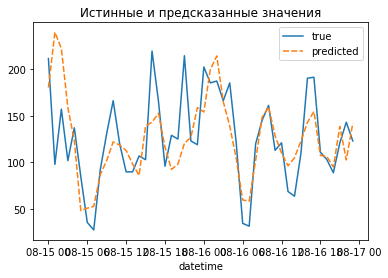

In [30]:
sns.lineplot(data=part_data).set_title('Истинные и предсказанные значения')

Видим, что модель не столько усредняет результаты, сколько старается повторить пики и спады. Получается у нее относительно неплохо

<a id='result'></a>
#### Вывод

Удалось добиться хорошего качества. Ощутимо лучше, чем при наивном предсказании без использования алгоритмов машинного обучения.

Это качество можно улучшать и в дальнейшем, если брать больше данных. Например, города, районы, погоду и многие другие факторы. Так же можно учитывать и локальные моменты. Например, если какое-то предприятие оплачивает регулярно своим работникам(клиентам) такси, можно воспользоваться и этим.